In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from sklearn.metrics import roc_curve, auc
from omegaconf import OmegaConf, DictConfig
from hydra import compose, initialize

from vbf_tagger.models.LorentzNet import classification
from vbf_tagger.tools.data.dataloaders import VBFDataModule

In [3]:
# Load Hydra config
with initialize(version_base=None, config_path="../config", job_name="visualize"):
    cfg = compose(config_name="main")

# Load checkpoint
ckpt_path = "/home/norman/vbf-tagger/outputs/pairs_3/classification/models/model_best.ckpt"
checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

hyperparams = checkpoint["hyper_parameters"]
model = classification(name="classification", hyperparameters=hyperparams)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

classification(
  (model): LorentzNet(
    (embedding): Linear(in_features=25, out_features=128, bias=True)
    (LGEBs): ModuleList(
      (0-2): 3 x LGEB(
        (phi_e): Sequential(
          (0): Linear(in_features=258, out_features=128, bias=False)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=128, out_features=128, bias=True)
          (4): ReLU()
        )
        (phi_h): Sequential(
          (0): Linear(in_features=281, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=128, out_features=128, bias=True)
        )
        (phi_x): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=1, bias=False)
        )
        (phi_m): Sequential(
          

In [4]:
# Override dataset info
cfg.dataset = OmegaConf.create({
    "datasets": {
        "vbf":   "/home/norman/vbf-tagger/vbf_tagger/data/22pre/hh_vbf/preprocessed_filtered/",
    },
    "train_dataset": ["vbf"],
    "val_dataset": ["vbf"],
    "test_dataset": ["vbf"],
    "train_dir": "train",
    "val_dir": "val",
    "test_dir": "test",
})

# Create DataModule
dm = VBFDataModule(cfg=cfg, data_type="", device="cpu")
dm.setup(stage="fit")
train_loader = dm.train_dataloader()

dm.setup(stage="test")
test_loader = dm.test_dataloader()

There are 294,759 waveforms/events/jets in the dataset.
There are 294,759 waveforms/events/jets in the dataset.
[INFO] Computed pos_weight = 15.613 from training data
There are 42,114 waveforms/events/jets in the dataset.


In [5]:
def evaluate_loader(loader, model):
    all_probs, all_targets = [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            preds, targets, mask = model(batch)
            preds = preds[:, 2:, :]  # remove beams
            mask = mask.bool().reshape(-1)
            probs = torch.softmax(preds, dim=-1)[:, :, 1].reshape(-1)
            targets = targets.reshape(-1)
            all_probs.append(probs[mask].cpu())
            all_targets.append(targets[mask].cpu())
    return torch.cat(all_probs).numpy(), torch.cat(all_targets).numpy()

preds_train, y_train = evaluate_loader(train_loader, model)
preds_test,  y_test  = evaluate_loader(test_loader, model)

In [6]:
preds_train = np.clip(preds_train, 0.0, 1.0)
preds_test  = np.clip(preds_test, 0.0, 1.0)

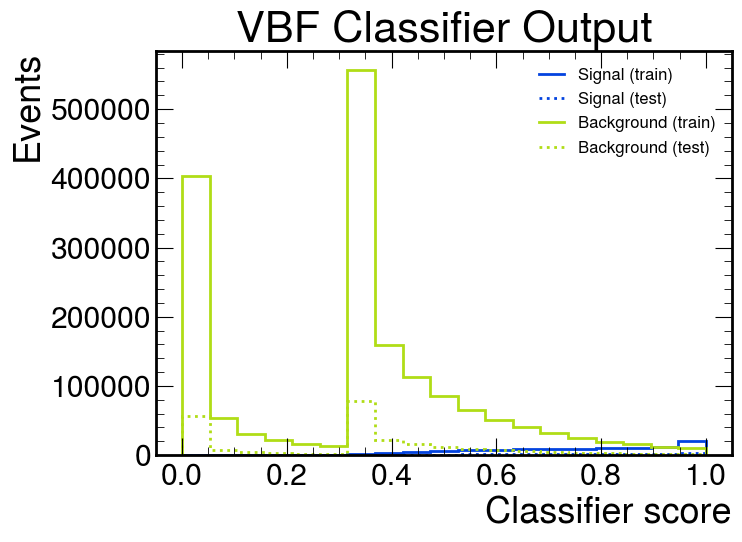

In [7]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(figsize=(8,6))

bins = np.linspace(0, 1, 20)

hep.histplot(
    np.histogram(preds_train[y_train==1], bins=bins),
    histtype='step', color='#0343df', label='Signal (train)', linewidth=2
)
hep.histplot(
    np.histogram(preds_test[y_test==1], bins=bins),
    histtype='step', color='#0343df', linestyle=':', label='Signal (test)', linewidth=2
)
hep.histplot(
    np.histogram(preds_train[y_train==0], bins=bins),
    histtype='step', color='#b0dd16', label='Background (train)', linewidth=2
)
hep.histplot(
    np.histogram(preds_test[y_test==0], bins=bins),
    histtype='step', color='#b0dd16', linestyle=':', label='Background (test)', linewidth=2
)

ax.set_xlabel("Classifier score")
ax.set_ylabel("Events")
ax.legend(fontsize=12)
ax.set_title("VBF Classifier Output")
plt.tight_layout()
plt.show()


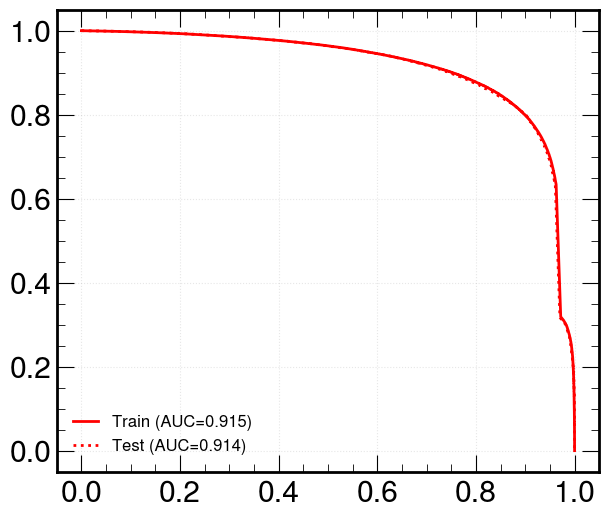

In [11]:
fpr_train, tpr_train, _ = roc_curve(y_train, preds_train)
fpr_test,  tpr_test,  _ = roc_curve(y_test, preds_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test  = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,6))
plt.plot(tpr_train, 1-fpr_train, label=f"Train (AUC={roc_auc_train:.3f})", color='red', linewidth=2)
plt.plot(tpr_test,  1-fpr_test,  label=f"Test (AUC={roc_auc_test:.3f})", color='red', linestyle=':', linewidth=2)
# plt.xlabel("Signal efficiency (TPR)")
# plt.ylabel("Background rejection (1 - FPR)")
plt.legend(fontsize=12)
# plt.title("ROC Curve — VBF Classifier")
plt.grid(alpha=0.3)
plt.show()

In [9]:
roc_auc_train

0.9151027362752917

In [10]:
roc_auc_test

0.9136049848889546